今回は線形関数近似の探索でよく出てくる[Improved Algorithms for Linear Stochastic Bandits](https://papers.nips.cc/paper/4417-improved-algorithms-for-linear-stochastic-bandits)を学びます。

前回も線形バンディットをやりましたが([contextual_bandit.ipynb](contextual_bandit.ipynb))、詳しい証明やよりよいバンディットについては触れてませんでした。
線形バンディットやLilnear MDPでタイトな性能を達成するためには、今回紹介する"self-normalized bound for vector-balued martingale"ってやつが大事になってきます。

--- 
**定理：Self-Normalized Bound for Vector Valued Martingales**

$\left\{F_t\right\}_{t=0}^{\infty}$をフィルトレーションとする。 
$\left\{\eta_t\right\}_{t=1}^{\infty}$を$\eta_t$が$F_t$-可測な実数値確率過程とする。また、$\eta_t$は条件付き$R$-sub-Gaussianとする ($R \geq 0$)。つまり、
$$
\forall \lambda \in \mathbb{R} \quad \mathbf{E}\left[e^{\lambda \eta_t} \mid F_{t-1}\right] \leq \exp \left(\frac{\lambda^2 R^2}{2}\right)
$$

$\left\{X_t\right\}_{t=1}^{\infty}$は$X_t$が$F_{t-1}$-可測である$\mathbb{R}^d$の確率過程とする。
$V$を$d \times d$の正則行列とする。任意の$t \geq 0$について、
$$
\bar{V}_t=V+\sum_{s=1}^t X_s X_s^{\top} \quad S_t=\sum_{s=1}^t \eta_s X_s .
$$
すると、任意の$\delta>0$について、最低でも確率$1-\delta$で、任意の$t \geq 0$について、
$$
\left\|S_t\right\|_{\bar{V}_t^{-1}}^2 \leq 2 R^2 \log \left(\frac{\operatorname{det}\left(\bar{V}_t\right)^{1 / 2} \operatorname{det}(V)^{-1 / 2}}{\delta}\right)
$$
が成り立つ。

---

ここで、マルチンゲールのぶれ$\left\|S_t\right\|_{\bar{V}_t^{-1}}^2$が$\bar{V}_t^{-1}$で測られていることに注意しましょう。
つまり、マルチンゲールのぶれ自体がマルチンゲールから出てきた量で測られているのでself-normalizedと呼ばれるんですね。

これを確認してみましょう。

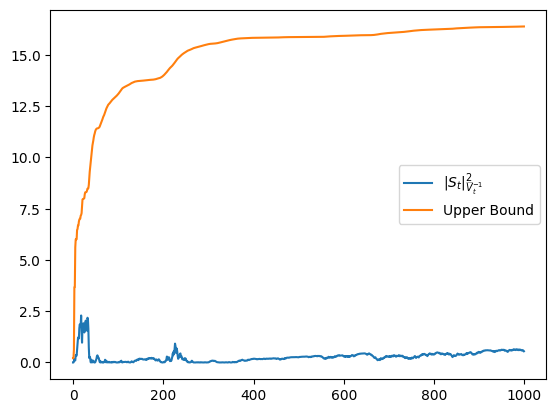

In [102]:
import numpy as np
import matplotlib.pyplot as plt

d = 10
length = 1000
R = 1
lam = 0.1  # V用のパラメータです
delta = 0.9  # 信頼パラメータです

# etaはR-sub gaussianにします
etas = (np.random.rand(length) - 0.5) * 2 * R
# X用に適当な確率過程を作っておきます
F = np.zeros((length, d))
for i in range(d):
    F[:, i] = etas * i

# Vは適当な正則行列です。今回はlambda * eyeとします。
V = 1 * np.eye(d)
S_t_norms = []
upper_bound = []
Xs = np.zeros((length, d))
for t in range(length):
    # Xは適当に時刻t-1から予想できるF_{t-1}-measurableな値にします
    if t == 0:
        pass
    else:
        Xs[t] = F[:t].sum(axis=0)

    V_t = V.copy()
    S_t = np.zeros(d)
    for i in range(t):
        X = Xs[i].reshape(d, 1)
        V_t += X @ X.T
        S_t += etas[i] * Xs[i]
    assert S_t.shape == (d,)

    # ノルムを計算します
    S_t_norms.append(S_t @ np.linalg.inv(V_t) @ S_t)

    # 上界を計算します
    y = np.log(np.sqrt(np.linalg.det(V_t)) / np.sqrt(np.linalg.det(V)) / delta)
    upper_bound.append(2 * R ** 2 * y)

plt.plot(S_t_norms, label=r"$\|S_t\|^2_{\widebar{V}_t^{-1}}$")
plt.plot(upper_bound, label=r"Upper Bound")
plt.legend()